In [ ]:
import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.nn import init
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import functional as FT

import copy

In [ ]:
train = CIFAR10(
    'data', 
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]), 
    download=True
)
train_dl = DataLoader(train, 32, shuffle=True, num_workers=4, drop_last=True)

test = CIFAR10(
    'validate', 
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]), 
    download=True
)
test_dl = DataLoader(test, 32, shuffle=False, num_workers=4, drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting validate/cifar-10-python.tar.gz to validate


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
LATENT_SPACE_DIM = 24

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
            
        
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, LATENT_SPACE_DIM)
        self.fc_bn2 = nn.BatchNorm1d(LATENT_SPACE_DIM)

        # self.fc3 = nn.Linear(LATENT_SPACE_DIM, 10)

        self.fc4 = nn.Linear(LATENT_SPACE_DIM, 2)
    
    def forward(self, x):        
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 8 * 8 * 64)

        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = F.relu(self.fc_bn2(self.fc2(x)))
        # supervised = self.fc3(x)
        embedding = self.fc4(x)
        return x, embedding

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(LATENT_SPACE_DIM, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64 * 8 * 8)
        self.fc_bn2 = nn.BatchNorm1d(64 * 8 * 8)

        self.conv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3)
        )
    
    def forward(self, z):
        x = F.relu(self.fc_bn1(self.fc1(z)))
        x = F.relu(self.fc_bn2(self.fc2(x))).view(-1, 64, 8, 8)
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        return F.sigmoid(x)

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_mu = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)
        self.enc_logvar = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)

    def forward(self, x):
        h, embedding = self.encoder(x)
        
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        sigma = (logvar * 0.5).exp_()
        z = mu + sigma * torch.randn_like(sigma)
        
        xh = self.decoder(z)
        
        return (mu, sigma), xh, h, embedding
    
    def sample(self, n=1):
        z = torch.randn(n, LATENT_SPACE_DIM, 
                        dtype=torch.float)
        
        xh = self.decoder(z)
        xh = xh.detach()
        
        return xh

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
            
        
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, LATENT_SPACE_DIM)
        self.fc_bn2 = nn.BatchNorm1d(LATENT_SPACE_DIM)

        self.fc3 = nn.Linear(LATENT_SPACE_DIM, 10)
    
    def forward(self, x, latent,train=True):
        if train:        
            x = self.conv1(x)
            x = self.conv2(x)

            x = x.view(-1, 8 * 8 * 64)

            x = F.relu(self.fc_bn1(self.fc1(x)))
            x = F.relu(self.fc_bn2(self.fc2(x)))
            # print(x.shape)
            # print(x[0])
            supervised = self.fc3(x)
        else:
            supervised = self.fc3(latent)
        return supervised

In [ ]:
def latent_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
device_cpu = torch.device("cpu")

In [ ]:
model = VAE(Encoder(), Decoder())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
classifier_cent_cri = CenterLoss(num_classes=10, feat_dim=2, use_gpu=True)

model.train()
classifier = Classifier()
path = "/content/gdrive/MyDrive/project/classifier.pth"
model_dict=torch.load(path)
classifier.load_state_dict(model_dict)
classifier = classifier.to(device)
classifier.eval()

for epoch in tqdm.tqdm_notebook(range(1, 40)):
    total_loss = 0
    without_total_loss = 0
    center_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, latent, embedding = model(x)

        supervised = classifier(x, latent, train=False)
        # loss = criterion(supervised, y)

        # loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)

        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)+ criterion(supervised, y) + classifier_cent_cri(embedding.float(), y)

        without_supervised_loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)

        center_loss += classifier_cent_cri(embedding.float(), y)

        # print(criterion(supervised, y).item())

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        without_total_loss += without_supervised_loss.item()

        # break
    
    total_loss /= len(train_dl)
    without_total_loss /= len(train_dl)
    center_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss} without_loss={without_total_loss} center_loss={center_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=1 loss=3.18274133542741 without_loss=0.7236272348102931 center_loss=1.0574688911437988


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=2.4983801871500004 without_loss=0.6524884227219678 center_loss=0.7899848222732544


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=2.2078263061299976 without_loss=0.6466380845035085 center_loss=0.6648740172386169


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=1.9976942967361129 without_loss=0.6440389735216367 center_loss=0.5770936608314514


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=1.8166175945620227 without_loss=0.643898191013959 center_loss=0.4999724328517914


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=1.672508239211865 without_loss=0.6438829757263658 center_loss=0.4423382878303528


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=1.554497039768363 without_loss=0.6439201047646405 center_loss=0.3968082070350647


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=1.4419261786452329 without_loss=0.644560101281055 center_loss=0.35067522525787354


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=1.3524630303648462 without_loss=0.6445914517596802 center_loss=0.31871309876441956


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=1.2971465981418742 without_loss=0.6449833504292785 center_loss=0.30308660864830017


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=1.2306847996656782 without_loss=0.644844307255348 center_loss=0.2769526243209839


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=1.179150330234276 without_loss=0.644879712070912 center_loss=0.2593640387058258


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=1.1424715619310069 without_loss=0.6449601986420445 center_loss=0.24941988289356232


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=1.1003202908933545 without_loss=0.6448121853125081 center_loss=0.2349797487258911


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=1.0696676555119464 without_loss=0.6445813544962684 center_loss=0.2246413230895996


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=1.0446070225458597 without_loss=0.6446368566472155 center_loss=0.21714630722999573


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=1.0195334739553792 without_loss=0.6441610495198551 center_loss=0.2075148969888687


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=1.0070976338298006 without_loss=0.6444784019347495 center_loss=0.20376470685005188


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=0.9905805880449493 without_loss=0.6438244775452778 center_loss=0.20176392793655396


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=20 loss=0.9685184149293374 without_loss=0.643912700432974 center_loss=0.19079534709453583


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=21 loss=0.9623713088096638 without_loss=0.6438370883922724 center_loss=0.18961265683174133


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=22 loss=0.9410385605849316 without_loss=0.6437571902739101 center_loss=0.18017804622650146


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=23 loss=0.9364450841035489 without_loss=0.6435750183695867 center_loss=0.1793506145477295


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=24 loss=0.9192936614670918 without_loss=0.6433569438249903 center_loss=0.1695256531238556


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=25 loss=0.9086540381444401 without_loss=0.6431368837054346 center_loss=0.16678519546985626


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.9000585719504216 without_loss=0.6428611998216138 center_loss=0.16189755499362946


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.9029459833869861 without_loss=0.6427618098396345 center_loss=0.16469500958919525


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.8874929374830366 without_loss=0.6427752252348559 center_loss=0.15769118070602417


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.8810340045508899 without_loss=0.6426479849253666 center_loss=0.1563674956560135


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.8723418525635968 without_loss=0.6423625832712146 center_loss=0.1498022973537445


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.8720499116083114 without_loss=0.6423127750046885 center_loss=0.15087231993675232


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.8657713526723937 without_loss=0.6422918812108254 center_loss=0.14820624887943268


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.8633020357270552 without_loss=0.6420156908020015 center_loss=0.1485028862953186


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.8500725675407659 without_loss=0.6418344718469701 center_loss=0.14115017652511597


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.853058397159381 without_loss=0.6414932409795084 center_loss=0.1429063379764557


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=36 loss=0.8401041973415624 without_loss=0.6412340714363679 center_loss=0.13596804440021515


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.8396296984254932 without_loss=0.6409803962051182 center_loss=0.13705655932426453


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.8364869141319192 without_loss=0.6409236327405166 center_loss=0.13396994769573212


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.8223111874849635 without_loss=0.6406565324216127 center_loss=0.1279219686985016


In [ ]:
criterion = nn.CrossEntropyLoss()
classifier_cent_cri = CenterLoss(num_classes=10, feat_dim=2, use_gpu=True)

model.train()
classifier = Classifier()
path = "/content/gdrive/MyDrive/project/classifier.pth"
model_dict=torch.load(path)
classifier.load_state_dict(model_dict)
classifier = classifier.to(device)
classifier.eval()

for epoch in tqdm.tqdm_notebook(range(1, 40)):
    total_loss = 0
    without_total_loss = 0
    center_loss = 0
    for x, y in tqdm.tqdm_notebook(train_dl):
        x = x.to(device)
        y = y.long().to(device)
        h, xh, latent, embedding = model(x)

        supervised = classifier(x, latent, train=False)
        # loss = criterion(supervised, y)

        # loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)

        # loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)+ criterion(supervised, y) + classifier_cent_cri(embedding.float(), y)

        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)+ criterion(supervised, y)

        without_supervised_loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)

        center_loss += classifier_cent_cri(embedding.float(), y)

        # print(criterion(supervised, y).item())

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        without_total_loss += without_supervised_loss.item()

        # break
    
    total_loss /= len(train_dl)
    without_total_loss /= len(train_dl)
    center_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss} without_loss={without_total_loss} center_loss={center_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/1562 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


i_epoch=1 loss=2.015886572121658 without_loss=0.7130718431155294 center_loss=2.926316738128662


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=2 loss=1.635585129489972 without_loss=0.6432827047517145 center_loss=3.88112211227417


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=3 loss=1.4705232902311942 without_loss=0.6388956234717644 center_loss=4.806639194488525


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=4 loss=1.3423845591297834 without_loss=0.6376267710507451 center_loss=5.762371063232422


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=5 loss=1.236040053118817 without_loss=0.637076970976843 center_loss=6.7510480880737305


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=6 loss=1.1459376964999528 without_loss=0.6364889209386482 center_loss=7.86414909362793


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=7 loss=1.0725387238662465 without_loss=0.6357969790887894 center_loss=9.206295013427734


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=8 loss=1.007531458719439 without_loss=0.635879692324603 center_loss=10.687394142150879


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=9 loss=0.9602078488633208 without_loss=0.6356457559995248 center_loss=11.947538375854492


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=10 loss=0.924883916726033 without_loss=0.6356528556301102 center_loss=13.388633728027344


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=11 loss=0.8850394278650248 without_loss=0.6355492896215559 center_loss=14.730565071105957


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=12 loss=0.8598402840074595 without_loss=0.6357641505141874 center_loss=16.188573837280273


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=13 loss=0.8403467321517983 without_loss=0.6357249146310682 center_loss=17.750608444213867


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=14 loss=0.822064245441659 without_loss=0.635305474303596 center_loss=19.08512306213379


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=15 loss=0.8054441410509176 without_loss=0.6348332733717221 center_loss=20.612775802612305


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=16 loss=0.7869345243166412 without_loss=0.6348427223869231 center_loss=22.26363182067871


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=17 loss=0.7833327784581008 without_loss=0.6347817287097056 center_loss=23.23573112487793


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=18 loss=0.770727706627107 without_loss=0.6344671477199975 center_loss=24.388526916503906


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=19 loss=0.7629584744858834 without_loss=0.634004304030488 center_loss=25.51163101196289


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=20 loss=0.7586944832081374 without_loss=0.6341487297099012 center_loss=26.68238639831543


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=21 loss=0.7499696085379768 without_loss=0.6337866102382255 center_loss=27.67947006225586


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=22 loss=0.7415003046183519 without_loss=0.6335958359183483 center_loss=28.740312576293945


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=23 loss=0.7396704295838535 without_loss=0.6332025193298061 center_loss=29.73808479309082


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=24 loss=0.7322877950384431 without_loss=0.6327939067469974 center_loss=30.995868682861328


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=25 loss=0.7294464166277349 without_loss=0.6324648347310007 center_loss=32.103111267089844


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=26 loss=0.7197357613817525 without_loss=0.6326415409046617 center_loss=32.8129768371582


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=27 loss=0.720218879274461 without_loss=0.6324206343762548 center_loss=33.81736373901367


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=28 loss=0.7206762008340349 without_loss=0.6325119879578506 center_loss=35.25187683105469


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=29 loss=0.7135662541804637 without_loss=0.632145230275568 center_loss=36.135894775390625


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=30 loss=0.7151098594012242 without_loss=0.6319735702723456 center_loss=36.99730682373047


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=31 loss=0.7047816914495524 without_loss=0.6320338024830543 center_loss=37.86151123046875


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=32 loss=0.7064114369060868 without_loss=0.631858369108962 center_loss=38.52883529663086


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=33 loss=0.7005347618296571 without_loss=0.631604717727202 center_loss=39.52731704711914


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=34 loss=0.701182096357077 without_loss=0.6314748440524527 center_loss=40.40299606323242


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=35 loss=0.6968702644529478 without_loss=0.6314337692019576 center_loss=41.47364044189453


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=36 loss=0.699574938885839 without_loss=0.6310854799921473 center_loss=42.20736312866211


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=37 loss=0.6960593698577294 without_loss=0.6313503254848924 center_loss=42.67899703979492


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=38 loss=0.6953475439060055 without_loss=0.6312230708657093 center_loss=43.78207778930664


  0%|          | 0/1562 [00:00<?, ?it/s]

i_epoch=39 loss=0.6921117799535451 without_loss=0.6311089009542624 center_loss=44.66324234008789


In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device_cpu))

        x = x.to(device_cpu)
        y = y.long().to(device_cpu)
        h, xh, supervised, embedding = model(x)

        # z = torch.Tensor.cpu(embedding)
        z = embedding.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=1.1)
        if i > num_batches:
            plt.colorbar()
            break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


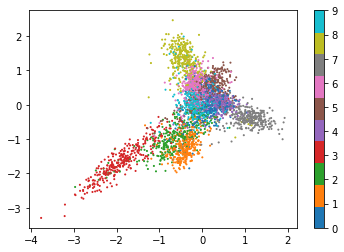

In [ ]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


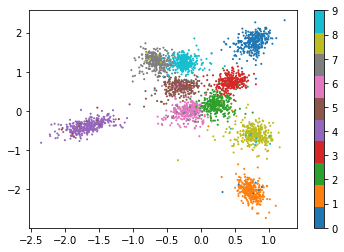

In [ ]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


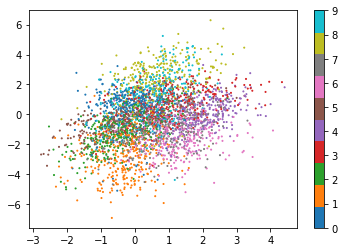

In [ ]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


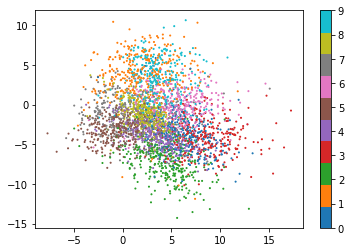

In [ ]:
model.eval()
model = model.to(device_cpu)

plot_latent(model, train_dl)

In [ ]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(x, self.centers.t(), beta=1, alpha=-2)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss